In [1]:
import cv2
import os
import random
import numpy as np
import time
import uuid
from matplotlib import pyplot as plt
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import load_model
import albumentations as alb
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import load_model

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
def load_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image


In [4]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120, 120)))
train_images = train_images.map(lambda x: x / 255)


2024-04-21 01:54:23.300310: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-04-21 01:54:23.300327: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-04-21 01:54:23.300332: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-04-21 01:54:23.300347: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-21 01:54:23.300356: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
train_images

<_MapDataset element_spec=TensorSpec(shape=(120, 120, 3), dtype=tf.float32, name=None)>

In [6]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x,(120,120)))
test_images = test_images.map(lambda x: x/255)

In [7]:
test_images

<_MapDataset element_spec=TensorSpec(shape=(120, 120, 3), dtype=tf.float32, name=None)>

In [8]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x,(120,120)))
val_images = val_images.map(lambda x: x/255)

In [9]:
val_images

<_MapDataset element_spec=TensorSpec(shape=(120, 120, 3), dtype=tf.float32, name=None)>

In [10]:
import tensorflow as tf
import json

def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding="utf-8") as f:
        label = json.load(f)
    return [label['class']], label['bbox']

def load_labels_wrapper(label_path):
    output = tf.py_function(load_labels, [label_path], [tf.uint8, tf.float16])
    # Directly set the shapes of the tensors without unpacking
    output[0].set_shape([1])  # Setting the shape for class label tensor
    output[1].set_shape([4])  # Assuming bbox contains 4 elements [x_min, y_min, x_max, y_max]
    return output


In [11]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(load_labels_wrapper)

train_labels


<_MapDataset element_spec=(TensorSpec(shape=(1,), dtype=tf.uint8, name=None), TensorSpec(shape=(4,), dtype=tf.float16, name=None))>

In [12]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(load_labels_wrapper)

test_labels


<_MapDataset element_spec=(TensorSpec(shape=(1,), dtype=tf.uint8, name=None), TensorSpec(shape=(4,), dtype=tf.float16, name=None))>

In [13]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(load_labels_wrapper)

val_labels


<_MapDataset element_spec=(TensorSpec(shape=(1,), dtype=tf.uint8, name=None), TensorSpec(shape=(4,), dtype=tf.float16, name=None))>

In [14]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(1480, 1480, 320, 320, 560, 560)

In [15]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [16]:
train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 120, 120, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(None, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 4), dtype=tf.float16, name=None)))>

In [17]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [18]:
test

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 120, 120, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(None, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 4), dtype=tf.float16, name=None)))>

In [19]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [20]:
val

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 120, 120, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(None, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 4), dtype=tf.float16, name=None)))>

In [21]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0]], dtype=uint8),
 array([[0.    , 0.224 , 0.2251, 0.6914],
        [0.405 , 0.2556, 0.805 , 0.723 ],
        [0.3499, 0.2947, 0.6587, 0.6597],
        [0.65  , 0.2471, 1.    , 0.771 ],
        [0.    , 0.3203, 0.3037, 0.777 ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.2151, 0.314 , 0.6587, 0.8076],
        [0.    , 0.    , 0.    , 0.    ]], dtype=float16))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


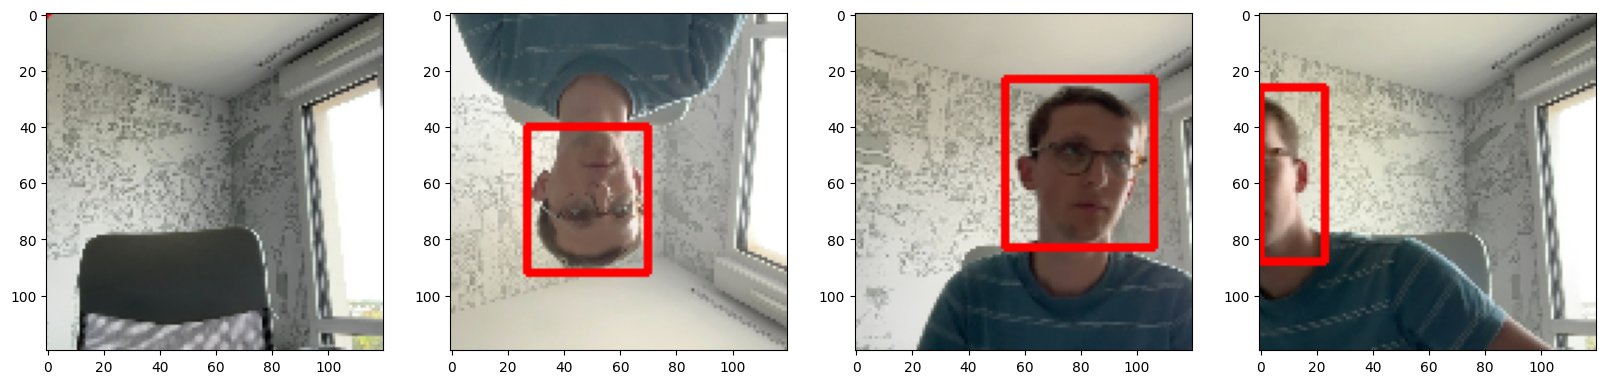

In [22]:
data_samples = train.as_numpy_iterator()
res = data_samples.next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    # Create a copy of the sample_image
    sample_image_copy = np.copy(sample_image)
    
    cv2.rectangle(sample_image_copy, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image_copy)

# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [23]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [24]:
vgg = VGG16(include_top=False)

### 8.3 Build instance of Network

In [50]:
def build_model(input_shape=(120, 120, 3)):
    input_layer = Input(shape=input_shape)
    base_model = VGG16(include_top=False, input_tensor=input_layer)
    
    # Feature extraction
    pooled_features = GlobalMaxPooling2D()(base_model.output)
    
    # Classification head
    classifier_output = Dense(2048, activation='relu')(pooled_features)
    classifier_output = Dense(1, activation='sigmoid', name='class_output')(classifier_output)
    
    # Regression head
    regressor_output = Dense(2048, activation='relu')(pooled_features)
    regressor_output = Dense(4, activation='sigmoid', name='bbox_output')(regressor_output)
    
    # Full model
    model = Model(inputs=input_layer, outputs=[classifier_output, regressor_output])
    return model


In [51]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [52]:
# Build and compile the model
facetracker = build_model()
facetracker.summary()
batches_per_epoch = len(train)
lr_decay = (1. / 0.75 - 1) / batches_per_epoch
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

facetracker.compile(optimizer=optimizer,
                    loss={'class_output': tf.keras.losses.BinaryCrossentropy(),
                          'bbox_output': localization_loss},
                    metrics={'class_output': ['accuracy'], 'bbox_output': []})

# Callbacks and training
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs')
hist = facetracker.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 120, 120,  │      1,792 │ input_layer_3[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 120, 120,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 60, 60,    │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 60, 60,    │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 60, 60,    │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 30, 30,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 30, 30,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 30, 30,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 30, 30,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 15, 15,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 15, 15,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 15, 15,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 15, 15,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 7, 7, 512) │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 7, 7, 512) │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 7, 7, 512) │  2,359,808 │ block5_conv1[0][

 Total params: 16,826,181 (64.19 MB)

 Trainable params: 16,826,181 (64.19 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/Users/arthurdesmazures/venv-metal/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:34: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
2024-04-21 01:26:28.647790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


185/185 ━━━━━━━━━━━━━━━━━━━━ 25s 114ms/step - class_output_accuracy: 0.8691 - loss: 1.0970 - val_class_output_accuracy: 0.9536 - val_loss: 0.4035
Epoch 2/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 23s 107ms/step - class_output_accuracy: 0.9934 - loss: 0.0898 - val_class_output_accuracy: 0.8732 - val_loss: 0.7187
Epoch 3/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - class_output_accuracy: 0.9969 - loss: 0.0448 - val_class_output_accuracy: 0.9500 - val_loss: 0.3410
Epoch 4/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 22s 111ms/step - class_output_accuracy: 0.9939 - loss: 0.0460 - val_class_output_accuracy: 0.9571 - val_loss: 0.4432
Epoch 5/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 22s 110ms/step - class_output_accuracy: 0.9960 - loss: 0.0818 - val_class_output_accuracy: 0.8679 - val_loss: 0.9225
Epoch 6/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 22s 110ms/step - class_output_accuracy: 0.9990 - loss: 0.0334 - val_class_output_accuracy: 0.9946 - val_loss: 0.2378
Epoch 7/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 23s 112ms/step - class_output

### 10.3 Plot Performance

In [26]:
hist.history

{'bbox_output_io_u': [nan, nan, nan, nan, nan],
 'class_output_accuracy': [0.7837837934494019,
  0.783108115196228,
  0.783108115196228,
  0.783108115196228,
  0.783108115196228],
 'loss': [-9.990303993225098,
  -10.258430480957031,
  -10.259732246398926,
  -10.259732246398926,
  -10.259736061096191],
 'val_bbox_output_io_u': [nan, nan, nan, nan, nan],
 'val_class_output_accuracy': [0.8571428656578064,
  0.8571428656578064,
  0.8571428656578064,
  0.8571428656578064,
  0.8571428656578064],
 'val_loss': [-6.728828430175781,
  -6.728827953338623,
  -6.728828430175781,
  -6.728828430175781,
  -6.728828430175781],
 'learning_rate': [9.999999747378752e-05,
  9.999999747378752e-05,
  9.999999747378752e-05,
  9.999999747378752e-05,
  9.999999747378752e-05]}

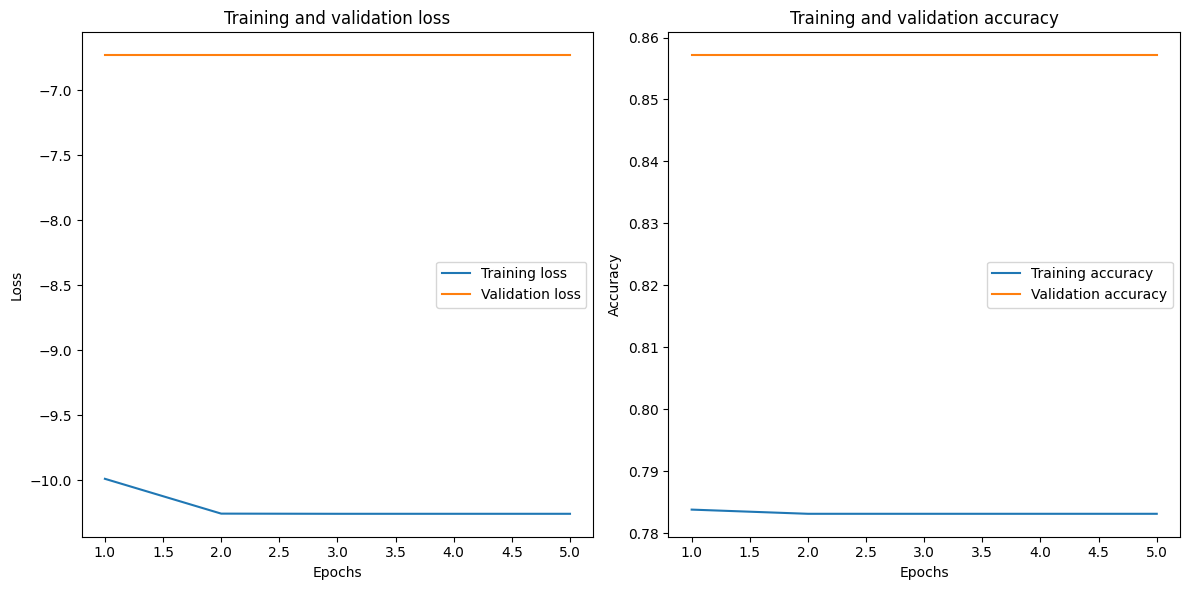

In [27]:
import matplotlib.pyplot as plt

# Extracting data from the training history
history_dict = hist.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['class_output_accuracy']  # This might differ based on your specific outputs
val_acc_values = history_dict['val_class_output_accuracy']  # This might differ too

epochs = range(1, len(loss_values) + 1)

# Plotting the training and validation loss
plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values, label='Training loss')
plt.plot(epochs, val_loss_values, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, acc_values, label='Training accuracy')
plt.plot(epochs, val_acc_values, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [28]:
test_data = test.as_numpy_iterator()

In [29]:
test_sample = test_data.next()

In [30]:
yhat = facetracker.predict(test_sample[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


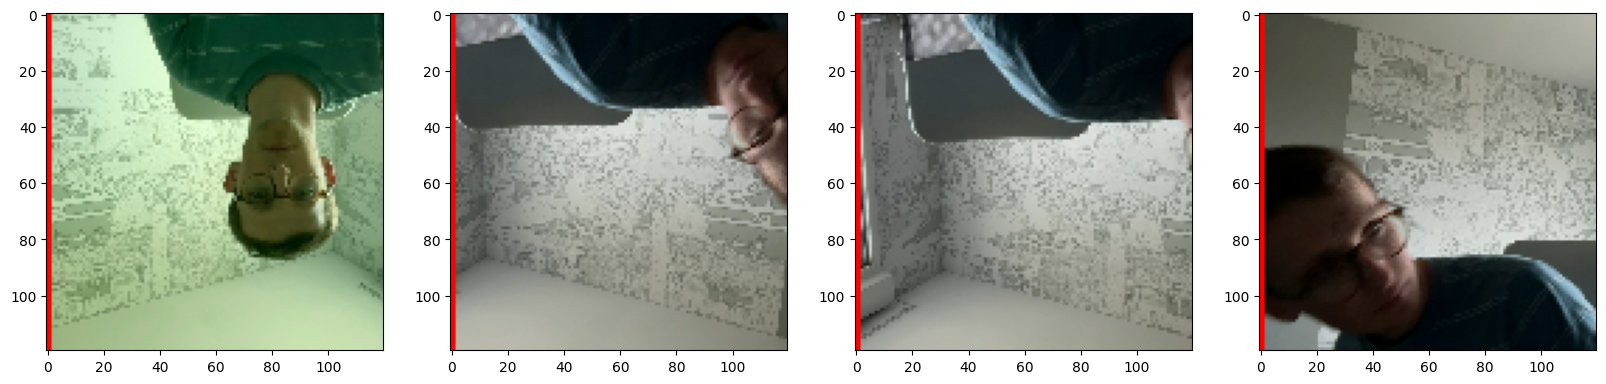

In [31]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx].copy()  # Create a copy of the image array
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)


### 11.2 Save the Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
facetracker.save('facetracker.h5')

In [ ]:
# facetracker = load_model('facetracker.h5')

TypeError: <class 'keras.src.metrics.iou_metrics.IoU'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.metrics', 'class_name': 'IoU', 'config': None, 'registered_name': None}.

Exception encountered: IoU.__init__() missing 2 required positional arguments: 'num_classes' and 'target_class_ids'

### 11.3 Real Time Detection

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [frame.shape[1],frame.shape[0]]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [frame.shape[1],frame.shape[0]]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [frame.shape[1],frame.shape[0]]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [frame.shape[1],frame.shape[0]]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [frame.shape[1],frame.shape[0]]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()


2024-04-21 01:44:21.560 Python[70059:2113844] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-04-21 01:44:23.185 Python[70059:2113844] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

KeyboardInterrupt: 

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[0:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━

KeyboardInterrupt: 

In [ ]:
val_images

<_MapDataset element_spec=TensorSpec(shape=(120, 120, 3), dtype=tf.float32, name=None)>